# Cell State Regression of 64D LSTM

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

# Load the data

In [2]:
run_dir = Path("/datadrive/data/runs/complexity_AZURE/hs_064_0306_205514")

# GET config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

# GET preds
res_fp = get_test_filepath(run_dir, epoch=30)
preds = get_all_station_ds(res_fp)

# GET trained model
model = get_model(cfg).to(cfg.device)
_load_weights(model, cfg)

100%|██████████| 669/669 [00:00<00:00, 2051.59it/s]


Using the model weights from /datadrive/data/runs/complexity_AZURE/hs_064_0306_205514/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(25, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [3]:
ds = xr.open_dataset(Path("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc"))

# Extract cell state from model

In [4]:
from scripts.cell_state.extract_cell_state import get_cell_states

out_dir = run_dir / "cell_states"
if not out_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)

if not (out_dir / "cell_states.nc").exists():
    cn = get_cell_states(cfg, run_dir)
    cn.to_netcdf(out_dir / "cell_states.nc")
else:
    cn = xr.open_dataset(out_dir / "cell_states.nc")

In [5]:
cn

<xarray.Dataset>
Dimensions:     (date: 4018, dimension: 64, station_id: 669)
Coordinates:
  * date        (date) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
  * station_id  (station_id) object '10002' '10003' '1001' ... '96004' '97002'
  * dimension   (dimension) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
Data variables:
    c_n         (date, station_id, dimension) float32 ...

# Load soil moisture data (timeseries per catchment)

In [6]:
data_dir = Path("/datadrive/data")

# load in esa cci
esa_ds = xr.open_dataset(data_dir / "camels_basin_ESACCI_sm.nc")    
esa_ds["station_id"] = esa_ds.station_id.astype("int64")
esa_ds = esa_ds.sortby("time")

# Load normalized CellState and SoilMoisture data
- input =  `norm_cs_data`
- target = `norm_sm`

In [7]:
from scripts.cell_state.normalize import (normalize_xarray_cstate, normalize_xr_by_basin)

In [8]:
cs_data = cn.copy()
norm_cs_data = normalize_xarray_cstate(cs_data, cell_state_var="c_n")

Normalize: 100%|██████████| 64/64 [00:00<00:00, 1870.24it/s]


In [115]:
norm_cs_data["station_id"] = [int(sid) for sid in norm_cs_data["station_id"]]
if "date" in norm_cs_data.dims:
    norm_cs_data = norm_cs_data.rename({"date": "time"})

input_data = norm_cs_data.to_dataset().rename({"c_n": "cell_state"})

input_data_file = data_dir / "SOIL_MOISTURE/norm_cs_data.nc"
if not input_data_file.exists():
    input_data.to_netcdf(input_data_file)

In [10]:
norm_sm = normalize_xr_by_basin(esa_ds)
norm_sm["station_id"] = [int(sid) for sid in norm_sm["station_id"]]

### interpolate between gaps

In [48]:
from scripts.cell_state.cell_state_dataset import fill_gaps

In [49]:
norm_sm = fill_gaps(norm_sm, fill="interpolate")

Filling gaps with method interpolate: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, sm]


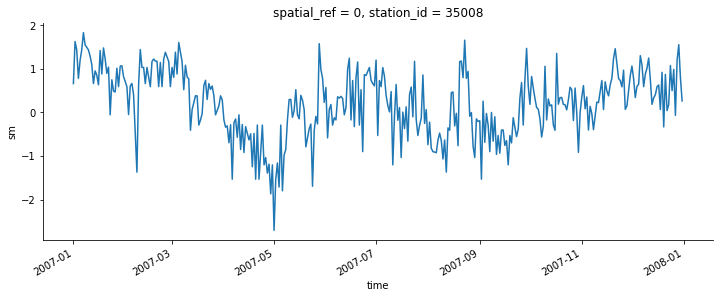

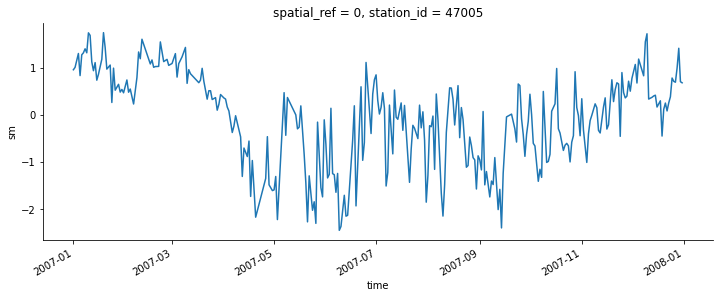

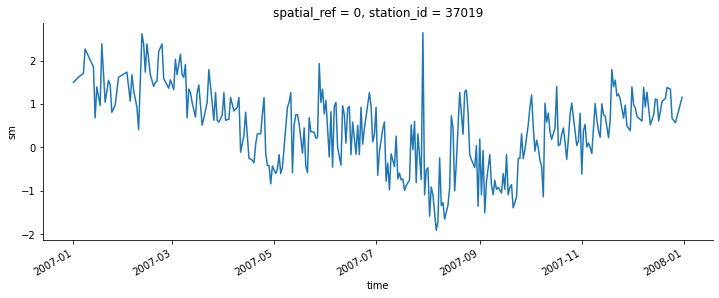

In [82]:
choices = np.random.choice(norm_sm.station_id.values, 3)

for px in choices:
    f, ax = plt.subplots(figsize=(12, 4))
    norm_sm.sel(station_id=px)["sm"].sel(time="2007").plot(ax=ax)
    sns.despine()

# random output

In [97]:
random_output = xr.ones_like(norm_sm) * np.random.normal(size=norm_sm["sm"].shape)

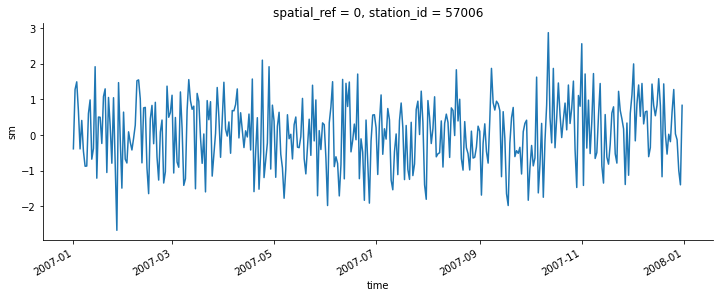

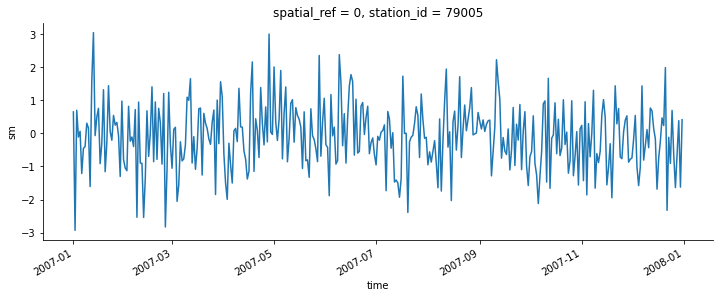

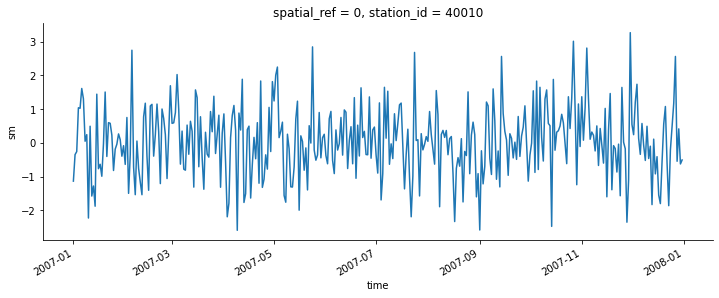

In [98]:
choices = np.random.choice(random_output.station_id.values, 3)

for px in choices:
    f, ax = plt.subplots(figsize=(12, 4))
    random_output.sel(station_id=px)["sm"].sel(time="2007").plot(ax=ax)
    sns.despine()

# Train Linear Probe

In [54]:
%load_ext autoreload 
%autoreload 2

from scripts.cell_state.cell_state_model import LinearModel, train_model, get_train_test_dataset, DataLoader, calculate_predictions
from scripts.cell_state.cell_state_dataset import CellStateDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
device = "cpu"
input_data = norm_cs_data.to_dataset().rename({"c_n": "cell_state"})

with warnings.catch_warnings(record=True):
    #  1. create dataset (input, target)
    dataset = CellStateDataset(
        input_data=input_data,  # "date": "time",
        target_data=random_output["sm"],
        start_date=norm_cs_data["time"].min().values,
        end_date=norm_cs_data["time"].max().values,
        device=device,
        fill=None,
    )

In [100]:
train_test = True

#  2. create train-test split
if train_test:
    #  build the train, test, validation
    train_dataset, test_dataset = get_train_test_dataset(dataset)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
else:
    train_dataset = dataset
    test_dataset = dataset
    test_loader = DataLoader(dataset, batch_size=256, shuffle=False)

In [101]:
#  3. initialise the model
model = LinearModel(D_in=dataset.dimensions, dropout=0.2)
model = model.to(device)

# Make predictions

In [102]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://discuss.pytorch.org/uploads/default/39a9f417cb836820174d71e9a9318d5ccc6191f3")

In [103]:
model, train_losses, _ = train_model(
    model,
    train_dataset,
    learning_rate=1e-3,
    n_epochs=5,
    l2_penalty=1,
    val_split=False,
)

Training Epoch: 100%|██████████| 5/5 [01:38<00:00, 19.65s/it]


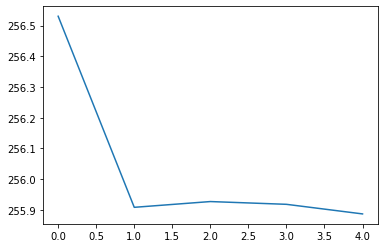

In [104]:
plt.plot(train_losses);

# Run predictions

In [105]:
from scripts.cell_state.cell_state_model import (calculate_predictions, get_all_models_weights, calculate_raw_correlations)
from scripts.read_nh_results import calculate_all_error_metrics

In [106]:
#  run forward pass and convert to xarray object
sm_preds = calculate_predictions(model, test_loader)

In [108]:
sm_preds.isnull().mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    y_hat    float64 0.0004971
    y        float64 0.0004971

In [109]:
# run evaluation on hold out set
with warnings.catch_warnings(record=True):
    errors = calculate_all_error_metrics(sm_preds, basin_coord="station_id", obs_var="y", sim_var="y_hat", time_coord="time")

Calculating Errors: 100%|██████████| 668/668 [00:51<00:00, 12.88it/s, 97002]


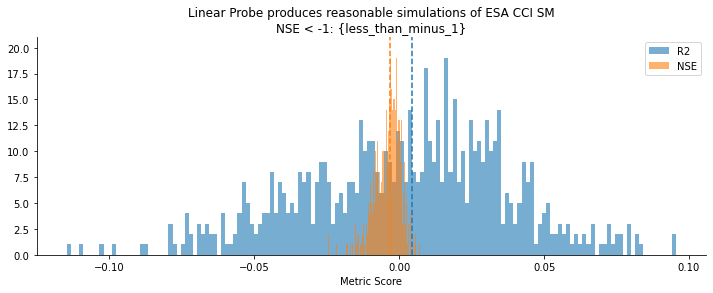

In [110]:
def flat_finite(arr):
    return arr[np.isfinite(arr)]

r2_score = flat_finite(errors["Pearson-r"].values)
nse_score = flat_finite(errors["NSE"].values)
less_than_minus_1 = (nse_score < -1).sum()
nse_score = nse_score[(nse_score > -1)]

f, ax = plt.subplots(figsize=(12, 4))
ax.hist(r2_score, alpha=0.6, bins=150, label="R2", color="C0");
ax.axvline(np.median(r2_score), ls="--", color="C0")
ax.hist(nse_score, alpha=0.6, bins=150, label="NSE", color="C1");
ax.axvline(np.median(nse_score), ls="--", color="C1")

ax.legend()
ax.set_title("Linear Probe produces reasonable simulations of ESA CCI SM\nNSE < -1: {less_than_minus_1}")
ax.set_xlabel("Metric Score")
sns.despine()

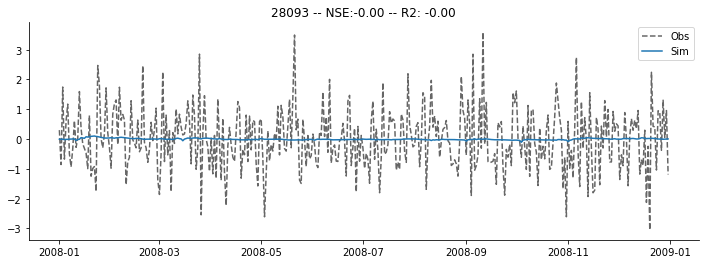

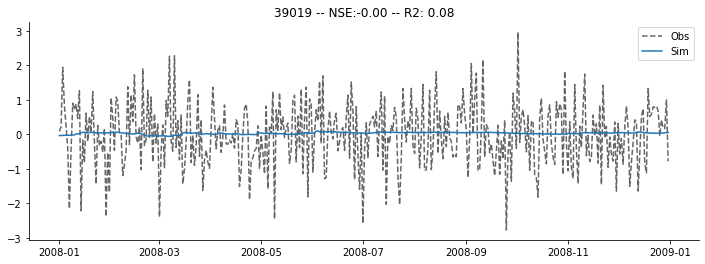

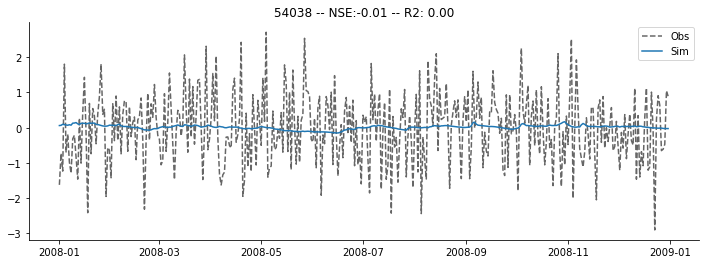

In [111]:
for _ in range(3):
    sid = np.random.choice(sm_preds.station_id.values)
    f, ax = plt.subplots(figsize=(12, 4))
    data = sm_preds.sel(station_id=sid, time="2008")
    ax.plot(data["time"], data["y"], label="Obs", ls="--", color="k", alpha=0.6)
    ax.plot(data["time"], data["y_hat"], label="Sim")
    
    
    r2 = float(errors["Pearson-r"].sel(station_id=sid).values)
    nse = float(errors["NSE"].sel(station_id=sid).values)
    
    ax.set_title(f"{sid} -- NSE:{nse:.2f} -- R2: {r2:.2f}")
    ax.legend()
    sns.despine()

# Evaluation

In [112]:
# extract weights and biases
print("-- Extracting weights and biases --")
ws, bs = get_all_models_weights([model])

-- Extracting weights and biases --


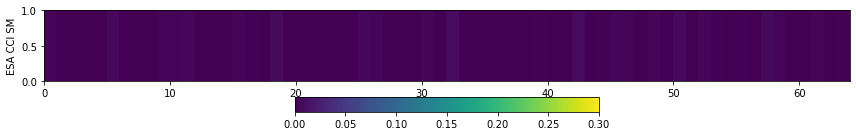

In [113]:
# weights = ws
f, ax = plt.subplots(figsize=(12, 2))
im = ax.pcolormesh(ws, vmin=0, vmax=0.3)
ax.set_ylabel(f"ESA CCI SM")

plt.colorbar(im, orientation='horizontal')
plt.tight_layout()

In [71]:
assert False

#  calculate raw correlations (cell state and values)
print("-- Running RAW Correlations --")
all_corrs = calculate_raw_correlations(norm_sm=norm_sm, cs_data=input_data, variable_str="sm")

AssertionError: 

# Evaluation Plots